In [1]:
# import PyQt5
# %matplotlib qt
%matplotlib inline 
import skimage.io
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.signal
import cv2
from scipy.interpolate import interpn
from tqdm.auto import tqdm
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.transforms as mtransforms

import sys
sys.path.append("/Users/prachigarg/Desktop/assgn5/src") 
from cp_hw5 import integrate_poisson, integrate_frankot, load_sources

from skimage.transform import resize

/Users/prachigarg/opt/anaconda3/envs/CV/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Entropy minimization

In [2]:
def normalize_tiff(img):
    return img/(2.0**16.0 - 1.0)

In [3]:
def convert_xyz(img):
    M_RGB_XYZ = np.array([[0.4124564, 0.3575761, 0.1804375],
     [0.2126729, 0.7151522, 0.0721750],
     [0.0193339, 0.1191920, 0.9503041]])
    xyz = np.matmul(img, M_RGB_XYZ)
    lumi_channel = xyz[:, :, 1]
    return lumi_channel
def crop(img):
    return img[1200:-200, 1800:4300]

0.0 0.667551689936675
2616 2500


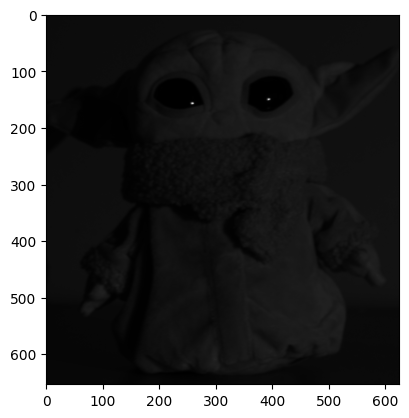

0.0 1.0
2616 2500


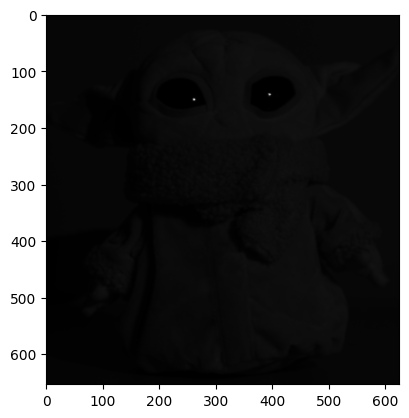

0.0 1.0
2616 2500


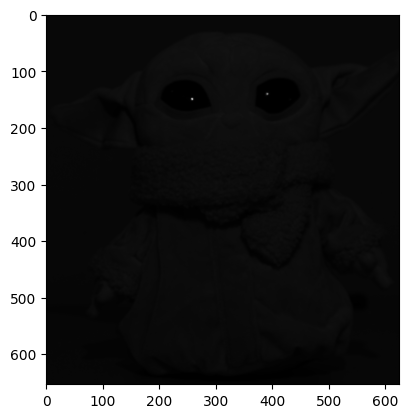

0.0 1.0
2616 2500


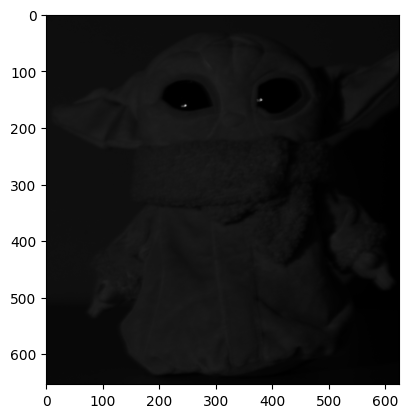

0.0 1.0
2616 2500


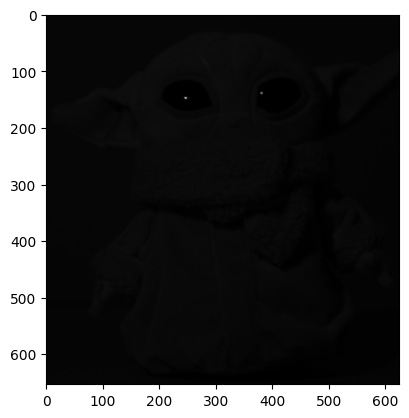

0.0 1.0
2616 2500


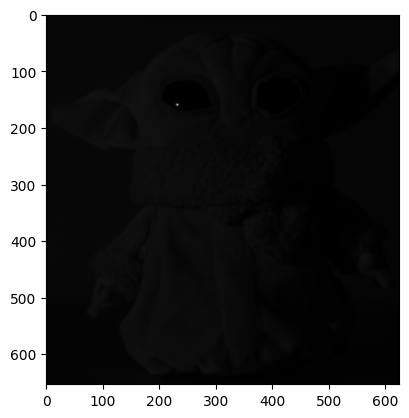

(6, 408750)


In [6]:
I = []
h = 0
w = 0
for id in range(2, 8, 1):
    img = skimage.io.imread('data/photometric_stereo2/DSC_{}.tiff'.format(id))
    img = normalize_tiff(img)
    print(img.min(), img.max())
    luminance = convert_xyz(img)
    
    luminance = crop(luminance)
    
    h, w = luminance.shape
    print(h, w)
    luminance = resize(luminance, (h/4, w/4))
    
    plt.imshow(luminance, cmap='gray')
    plt.show()
    h, w = luminance.shape
    I.append(luminance.flatten())
I = np.stack(I, axis=0)

print(I.shape)

In [7]:
h, w

(654, 625)

In [8]:
def map_normal(normal_img):
    return (normal_img + 1.0)/2.0

def decompose_pseudo_normal(B):
    # input shape B: (3, HxW)
    # returns albedo and norm
    print(f'check B {B.shape}')
    A = np.linalg.norm(B, axis=0)
    N = B / A
    print(A.shape, N.shape)

    A = np.reshape(A, (h, w))
    N = np.reshape(N.T, (h, w, 3))
    print(f'reshaped albedo {A.shape}, reshaped normal map {N.shape}')
    
    N_vis = map_normal(N)
    print(N_vis.min(), N_vis.max())
    
    return A, N_vis

def normalize_01(depth):
    return (depth - depth.min()) / (depth.max() - depth.min())

In [9]:
# rank 3 decomposition
U, S, Vh = np.linalg.svd(I, full_matrices=False)
S = np.diag(S)
print(U.shape, S.shape, Vh.shape)
singular_vals = np.sqrt(S)[:3, :3]
print(singular_vals)

Le = np.matmul(U[:, :3], singular_vals)
Be = np.matmul(singular_vals, Vh[:3, :])
print(Le.shape, Be.shape)

(6, 6) (6, 6) (6, 408750)
[[6.81355675 0.         0.        ]
 [0.         3.56081079 0.        ]
 [0.         0.         2.23084134]]
(6, 3) (3, 408750)


In [11]:
be = np.reshape(np.transpose(Be), (h, w, 3))

# apply blur
sigma = 4.0
be_blur = []
for i in range(3):
    channel_blur = scipy.ndimage.gaussian_filter(be[:, :, i], sigma)
    be_blur.append(channel_blur)
be_blur = np.stack(be_blur, axis=2)
print(be_blur.shape)

# x and y gradients 
dx = np.gradient(be_blur, axis=1)
dy = np.gradient(be_blur, axis=0)
print(dx.shape, dy.shape)

(654, 625, 3)
(654, 625, 3) (654, 625, 3)


In [12]:
be_allpix = np.reshape(be, (-1, 3))
dx_allpix = np.reshape(dx, (-1, 3))
dy_allpix = np.reshape(dy, (-1, 3))
print(be_allpix.shape)
# A
A1 = (be_allpix[:, 0] * dx_allpix[:, 1]) - (be_allpix[:, 1] * dx_allpix[:, 0])
A2 = (be_allpix[:, 0] * dx_allpix[:, 2]) - (be_allpix[:, 2] * dx_allpix[:, 0])
A3 = (be_allpix[:, 1] * dx_allpix[:, 2]) - (be_allpix[:, 2] * dx_allpix[:, 1])
A4 = -(be_allpix[:, 0] * dy_allpix[:, 1]) + (be_allpix[:, 1] * dy_allpix[:, 0])
A5 = -(be_allpix[:, 0] * dy_allpix[:, 2]) + (be_allpix[:, 2] * dy_allpix[:, 0])
A6 = -(be_allpix[:, 1] * dy_allpix[:, 2]) + (be_allpix[:, 2] * dy_allpix[:, 1])

A_mat = np.stack((A1, A2, A3, A4, A5, A6), axis=1)
A_mat.shape

(408750, 3)


(408750, 6)

In [13]:
u, s, vh = np.linalg.svd(A_mat, full_matrices=False)
print(u.shape, vh.shape)
x = vh[-1, :] # null space, last row of vh
print(x)
delta = np.array([[-x[2], x[5], 1], [x[1], -x[4], 0], [-x[0], x[3], 0]])
print(delta)

(408750, 6) (6, 6)
[-0.22801004 -0.78741552  0.39010653  0.27884242  0.11623687  0.29075938]
[[-0.39010653  0.29075938  1.        ]
 [-0.78741552 -0.11623687  0.        ]
 [ 0.22801004  0.27884242  0.        ]]


In [14]:
delta_inv = np.linalg.inv(delta)
print(delta_inv.shape, be.shape)
be_integrate = np.matmul(delta_inv, Be)
print(be_integrate.shape)

(3, 3) (654, 625, 3)
(3, 408750)


### modified for entropy minimization

In [48]:
# Apply GBR and return albedo and normals
def apply_GBR(be_integrate, lamda=-1, mu=0, vu=0):
    print(f'lambda {lamda}, mu {mu}, v {vu}')
    G_f = np.array([[1, 0, 0], [0, 1, 0], [mu, vu, lamda]])
    G_temp = np.linalg.inv(G_f)
    be_integrate_ = np.matmul(G_temp, be_integrate)
    A_int, N_int = decompose_pseudo_normal(be_integrate_)
    A_int = (A_int - A_int.min()) / (A_int.max() - A_int.min())
    
    return A_int, N_int

In [77]:
lamda_values = np.arange(0, 5, 1)
mu_values = np.arange(-5, 5, 1)
v_values = np.arange(-5, 5, 1)
min_entropy = 10.0
req_lamda = 6.0
req_mu = 6.0
req_vu = 6.0

for l in lamda_values:
    if l == 0:
        continue
    for m in mu_values:
        for v in v_values:
            Albedo, _ = apply_GBR(be_integrate, l, m, v)
            print(Albedo.min(), Albedo.max())
            hist = np.histogram(Albedo, bins=256, range=(1e-3, 1.0))[0]
            hist = hist / hist.sum()
            entropy = -(hist * np.log(hist+1e-4)).sum()
            print(entropy)
            
            if entropy < min_entropy:
                min_entropy = entropy
                req_lamda = l
                req_mu = m
                req_vu = v

print(f'lambda {req_lamda}, mu {req_mu}, v {req_vu}')

lambda 1, mu -5, v -5
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
1.356441105215822e-06 0.9999796003652518
0.0 1.0
1.6198996043039176
lambda 1, mu -5, v -4
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
1.3516521488177169e-06 0.9999593412217751
0.0 1.0
1.6922903521141253
lambda 1, mu -5, v -3
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
1.3468885089462646e-06 0.999986547747751
0.0 1.0
1.8889173175329306
lambda 1, mu -5, v -2
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
1.3421500076882253e-06 0.9999808185507046
0.0 1.0
2.290052339694853
lambda 1, mu -5, v -1
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
1.3374364682960938e-06 0.999998234261801
0.0 1.0
2.8461223874580663
lambda 1, mu -5, v 0
check B 

(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
1.3123060228492633e-06 0.9999866345894148
0.0 1.0
2.122344923365432
lambda 1, mu -1, v 2
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
1.3077486866741594e-06 0.9999913112260113
0.0 1.0
1.998029560132018
lambda 1, mu -1, v 3
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
1.3032150493197392e-06 0.9999947422667181
0.0 1.0
1.9519303630858893
lambda 1, mu -1, v 4
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
1.298704946528506e-06 0.9999951979063302
0.0 1.0
1.9227419350807846
lambda 1, mu 0, v -5
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
1.3361318909055342e-06 0.999999801409442
0.0 1.0
1.7136396765108348
lambda 1, mu 0, v -4
check B (3, 408750)
(408750,) (3, 408750)
reshaped alb

(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
1.3202111300847363e-06 0.9999932103225195
0.0 1.0
1.998155023984191
lambda 1, mu 4, v -4
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
1.3156125892033188e-06 0.9999854281046237
0.0 1.0
2.0525561179716694
lambda 1, mu 4, v -3
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
1.3110380328584803e-06 0.9999788608567506
0.0 1.0
2.133012184571316
lambda 1, mu 4, v -2
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
1.3064872946833006e-06 0.9999886010723493
0.0 1.0
2.2672805406581005
lambda 1, mu 4, v -1
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
1.3019602093655713e-06 0.9999978650793448
0.0 1.0
2.4911288474135866
lambda 1, mu 4, v 0
check B (3, 408750)
(408750,) (3, 408750)
reshaped al

1.7422341711864564
lambda 2, mu -2, v -2
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
5.3203438744597875e-06 0.9999844428509128
0.0 1.0
1.8433130339311412
lambda 2, mu -2, v -1
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
5.30174324286925e-06 0.9999959810936776
0.0 1.0
1.9903540749052016
lambda 2, mu -2, v 0
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
5.283239985887089e-06 0.9999808895187096
0.0 1.0
2.112903383905983
lambda 2, mu -2, v 1
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
1.5391249739704627e-06 0.9999842489220735
0.0 1.0
2.1186654741731696
lambda 2, mu -2, v 2
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
5.24652288791394e-06 0.9999872707418128
0.0 1.0
2.0591108114487358
lambda 2, mu -2

5.296595024351092e-06 0.9999963797211685
0.0 1.0
1.9309183350234502
lambda 2, mu 3, v -4
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
4.8175957975682415e-06 0.9999954670131432
0.0 1.0
1.9627790087093677
lambda 2, mu 3, v -3
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
3.9222627467583315e-06 0.999993869041974
0.0 1.0
2.000387840653181
lambda 2, mu 3, v -2
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
3.1231495113415164e-06 0.9999890017867659
0.0 1.0
2.0674782797037308
lambda 2, mu 3, v -1
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
2.4202574753218187e-06 0.9999973928565704
0.0 1.0
2.1239221471467795
lambda 2, mu 3, v 0
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
1.8135878561698071e-06 0.995843975

0.0 1.0
2.0874247748165247
lambda 3, mu -3, v 1
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
8.263543822550901e-07 0.9999931914895822
0.0 1.0
2.1058013503005624
lambda 3, mu -3, v 2
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
4.435615540587801e-06 0.9999917714031548
0.0 1.0
2.079742364153909
lambda 3, mu -3, v 3
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
1.0977691907165799e-05 0.999990203833456
0.0 1.0
2.041947220615949
lambda 3, mu -3, v 4
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
9.39449624398625e-06 0.9999884887846477
0.0 1.0
2.007797415473721
lambda 3, mu -2, v -5
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
1.2097414091638559e-05 0.9999923006630673
0.0 1.0
1.7124331317042727
lambda 3, 

1.8946765441086997
lambda 3, mu 2, v -3
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
1.792706589842652e-07 0.999995382500757
0.0 1.0
1.9294462172053894
lambda 3, mu 2, v -2
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
1.4241776408185913e-07 0.9999906166350894
0.0 1.0
1.9604813375362344
lambda 3, mu 2, v -1
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
1.1048199638485912e-07 0.9999985361780571
0.0 1.0
1.9714312619411145
lambda 3, mu 2, v 0
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
8.346335872433386e-08 0.9959407227388603
0.0 1.0
1.9494496109103372
lambda 3, mu 2, v 1
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
6.136185343175171e-08 0.9637100194283221
0.0 1.0
1.9097606301576906
lambda 3, mu 2, v

2.084786098740296
lambda 4, mu -4, v 3
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
1.002149254819562e-05 0.9999947531413056
0.0 1.0
2.0615824176033977
lambda 4, mu -4, v 4
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
1.0279841917815169e-05 0.9999936214205145
0.0 1.0
2.035956314781395
lambda 4, mu -3, v -5
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
2.1570886731658856e-05 0.9999989303568403
0.0 1.0
1.750191530057892
lambda 4, mu -3, v -4
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
2.1494963991286475e-05 0.99999862935031
0.0 1.0
1.79189560442243
lambda 4, mu -3, v -3
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
2.141944137434848e-05 0.9999982453741902
0.0 1.0
1.852074846898887
lambda 4, mu -3, v

(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
1.6107093118722382e-05 0.9999990210056069
0.0 1.0
1.9216072406273055
lambda 4, mu 1, v 0
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
1.2607438811262917e-05 0.9970687638948981
0.0 1.0
1.9238457280514778
lambda 4, mu 1, v 1
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
2.322318273795254e-07 0.9888451294483344
0.0 1.0
1.9119613131855897
lambda 4, mu 1, v 2
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
1.1893035131715912e-06 0.9906508388553374
0.0 1.0
1.8890147131967963
lambda 4, mu 1, v 3
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
6.426034316886486e-06 0.9924977191721608
0.0 1.0
1.8617762043308637
lambda 4, mu 1, v 4
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo

In [78]:
min_entropy

1.57521472630109

In [79]:
lamda_values = np.linspace(req_lamda-1.0, req_lamda+1.0, num=8)
mu_values = np.linspace(req_mu-1.0, req_mu+1.0, num=8)
v_values = np.linspace(req_vu-1.0, req_vu+1.0, num=8)

for l in lamda_values:
    if l == 0:
        continue
    for m in mu_values:
        for v in v_values:
            Albedo, _ = apply_GBR(be_integrate, l, m, v)
            print(Albedo.min(), Albedo.max())
            hist = np.histogram(Albedo, bins=256, range=(1e-3, 1.0))[0]
            hist = hist / hist.sum()
            entropy = -(hist * np.log(hist+1e-4)).sum()
            print(entropy)
            
            if entropy < min_entropy:
                min_entropy = entropy
                req_lamda = l
                req_mu = m
                req_vu = v

print(f'lambda {req_lamda}, mu {req_mu}, v {req_vu}')

lambda 0.2857142857142857, mu -4.0, v -6.0
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
1.1078694606148076e-07 0.9996198176470324
0.0 1.0
1.5763929976230002
lambda 0.2857142857142857, mu -4.0, v -5.714285714285714
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
1.1067495181427134e-07 0.9995485372703701
0.0 1.0
1.575869540262186
lambda 0.2857142857142857, mu -4.0, v -5.428571428571429
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
1.1056312726465123e-07 0.9995169684933733
0.0 1.0
1.57906722984632
lambda 0.2857142857142857, mu -4.0, v -5.142857142857143
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
1.1045147224608698e-07 0.9994832612235138
0.0 1.0
1.5876549605063388
lambda 0.2857142857142857, mu -4.0, v -4.857142857142858
check B (3, 408750)
(408750,) (3, 408750

1.1018172507704094e-07 0.9996676503483882
0.0 1.0
1.58886832222529
lambda 0.2857142857142857, mu -2.857142857142857, v -5.142857142857143
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
1.1007064715240489e-07 0.9999576141324844
0.0 1.0
1.5849612154493071
lambda 0.2857142857142857, mu -2.857142857142857, v -4.857142857142858
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
1.0995973709349016e-07 0.999802428825701
0.0 1.0
1.583056025249002
lambda 0.2857142857142857, mu -2.857142857142857, v -4.571428571428571
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
1.0984899456722985e-07 0.9999723796056934
0.0 1.0
1.5834693784429394
lambda 0.2857142857142857, mu -2.857142857142857, v -4.285714285714286
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
1.0973841924055705e-07 0.999

check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
4.4186992614880793e-07 0.9997842652253564
0.0 1.0
1.562796703958756
lambda 0.5714285714285714, mu -3.7142857142857144, v -5.142857142857143
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
4.414238852779029e-07 0.9998987307008443
0.0 1.0
1.5641978109756316
lambda 0.5714285714285714, mu -3.7142857142857144, v -4.857142857142858
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
4.4097851947810796e-07 0.9999012818133133
0.0 1.0
1.57145715063315
lambda 0.5714285714285714, mu -3.7142857142857144, v -4.571428571428571
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
4.4053382736164437e-07 0.9999962916943831
0.0 1.0
1.5834993944021223
lambda 0.5714285714285714, mu -3.7142857142857144, v -4.285714285714286
check B (3, 408750)
(408

0.0 1.0
1.605229159260178
lambda 0.5714285714285714, mu -2.2857142857142856, v -5.714285714285714
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
4.404104526622987e-07 0.9999876442142994
0.0 1.0
1.5988205011006402
lambda 0.5714285714285714, mu -2.2857142857142856, v -5.428571428571429
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
4.399666193033447e-07 0.9999816724511182
0.0 1.0
1.5928110373033546
lambda 0.5714285714285714, mu -2.2857142857142856, v -5.142857142857143
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
4.395234565190975e-07 0.999977763540713
0.0 1.0
1.5868973696311617
lambda 0.5714285714285714, mu -2.2857142857142856, v -4.857142857142858
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
4.390809630883119e-07 0.9999800937957622
0.0 1.0
1.5820114715924325

9.913439192321682e-07 0.9999963604345441
0.0 1.0
1.5703298855585626
lambda 0.8571428571428571, mu -3.428571428571429, v -4.571428571428571
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
9.903446596126741e-07 0.9999962940510965
0.0 1.0
1.578054166024357
lambda 0.8571428571428571, mu -3.428571428571429, v -4.285714285714286
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
9.893469101185381e-07 0.9999954791665553
0.0 1.0
1.5896782981279056
lambda 0.8571428571428571, mu -3.428571428571429, v -4.0
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
9.883506676411358e-07 0.9999950017388491
0.0 1.0
1.6082041672215004
lambda 0.8571428571428571, mu -3.142857142857143, v -6.0
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
9.944959236674045e-07 0.99997132461362
0.0 1.0
1.57474047

9.900674264318177e-07 0.9999561897999932
0.0 1.0
1.6060126075549925
lambda 0.8571428571428571, mu -2.0, v -5.428571428571429
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
9.890700957138066e-07 0.9999650055036859
0.0 1.0
1.6005715451333644
lambda 0.8571428571428571, mu -2.0, v -5.142857142857143
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
9.88074271235373e-07 0.9999722425786848
0.0 1.0
1.595500867065337
lambda 0.8571428571428571, mu -2.0, v -4.857142857142858
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
9.870799499434035e-07 0.9999887857792906
0.0 1.0
1.5916032938281028
lambda 0.8571428571428571, mu -2.0, v -4.571428571428571
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
9.86087128784785e-07 0.9999840253978809
0.0 1.0
1.5890454605119866
lambda 0.8571428571

1.755550683657514e-06 0.999988286792564
0.0 1.0
1.6200638659680136
lambda 1.1428571428571428, mu -2.857142857142857, v -6.0
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
1.7664614018753078e-06 0.9999548974994936
0.0 1.0
1.586872754929591
lambda 1.1428571428571428, mu -2.857142857142857, v -5.714285714285714
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
1.7646787833225375e-06 0.9999454027310416
0.0 1.0
1.5843732153011691
lambda 1.1428571428571428, mu -2.857142857142857, v -5.428571428571429
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
1.7628988617235386e-06 0.9999308770466435
0.0 1.0
1.582787958178824
lambda 1.1428571428571428, mu -2.857142857142857, v -5.142857142857143
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
1.761121631860263e-06 0.9999789169001227
0

(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
2.758477741504617e-06 0.9999782427791264
0.0 1.0
1.6157713075277182
lambda 1.4285714285714284, mu -4.0, v -4.571428571428571
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
2.7556948527518443e-06 0.9999961554508041
0.0 1.0
1.6301707374947252
lambda 1.4285714285714284, mu -4.0, v -4.285714285714286
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
2.7529161730210916e-06 0.9999667368306402
0.0 1.0
1.648732736647082
lambda 1.4285714285714284, mu -4.0, v -4.0
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
2.750141693985686e-06 0.9999699892873593
0.0 1.0
1.6721527827740699
lambda 1.4285714285714284, mu -3.7142857142857144, v -6.0
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
2.7672559423

(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
2.754922772463253e-06 0.9999545362503748
0.0 1.0
1.6039815522794978
lambda 1.4285714285714284, mu -2.5714285714285716, v -5.428571428571429
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
2.752145260187522e-06 0.9999584414010572
0.0 1.0
1.6046556327769799
lambda 1.4285714285714284, mu -2.5714285714285716, v -5.142857142857143
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
2.749371946164647e-06 0.9999803327489435
0.0 1.0
1.6072772944758889
lambda 1.4285714285714284, mu -2.5714285714285716, v -4.857142857142858
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
2.746602822067956e-06 0.9999907016339258
0.0 1.0
1.6123654111687085
lambda 1.4285714285714284, mu -2.5714285714285716, v -4.571428571428571
check B (3, 408750)
(408750,) (3, 408750)
re

(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
3.964762527841614e-06 0.9999964196832665
0.0 1.0
1.6453714755481232
lambda 1.7142857142857142, mu -3.7142857142857144, v -4.285714285714286
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
3.9607664339968984e-06 0.9999783037284318
0.0 1.0
1.6613549347955106
lambda 1.7142857142857142, mu -3.7142857142857144, v -4.0
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
3.956776378599702e-06 0.999976056796667
0.0 1.0
1.6804867409609054
lambda 1.7142857142857142, mu -3.428571428571429, v -6.0
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
3.981388812801523e-06 0.9999993743592837
0.0 1.0
1.6059552486210766
lambda 1.7142857142857142, mu -3.428571428571429, v -5.714285714285714
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), resh

3.951687024661421e-06 0.9999936360827928
0.0 1.0
1.6369780392502813
lambda 1.7142857142857142, mu -2.2857142857142856, v -4.571428571428571
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
3.947710677798533e-06 0.999994342495384
0.0 1.0
1.6431319194993899
lambda 1.7142857142857142, mu -2.2857142857142856, v -4.285714285714286
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
3.9437403295261575e-06 0.9999911029614328
0.0 1.0
1.651146065860891
lambda 1.7142857142857142, mu -2.2857142857142856, v -4.0
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
3.939775967909398e-06 0.9999896305315146
0.0 1.0
1.6624043115935232
lambda 1.7142857142857142, mu -2.0, v -6.0
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
3.964229706110434e-06 0.9999700213657492
0.0 1.0
1.6330511128463043


1.630751320386104
lambda 2.0, mu -3.142857142857143, v -5.428571428571429
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
5.403481826815604e-06 0.999994962403361
0.0 1.0
1.6360150449723976
lambda 2.0, mu -3.142857142857143, v -5.142857142857143
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
5.398032127901242e-06 0.9999951974437384
0.0 1.0
1.6421589235831928
lambda 2.0, mu -3.142857142857143, v -4.857142857142858
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
5.392590669228703e-06 0.9999954267029142
0.0 1.0
1.6504278070277478
lambda 2.0, mu -3.142857142857143, v -4.571428571428571
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
5.387157434200152e-06 0.9999962499275994
0.0 1.0
1.6621420987507953
lambda 2.0, mu -3.142857142857143, v -4.285714285714286
check B (3, 408

In [80]:
min_entropy, req_lamda, req_mu, req_vu

(1.5602712087139954, 0.8571428571428571, -4.0, -6.0)

In [81]:
A_int, N_int = apply_GBR(be_integrate, 0.8571428571428571, -4.0, -6.0)

lambda 0.8571428571428571, mu -4.0, v -6.0
check B (3, 408750)
(408750,) (3, 408750)
reshaped albedo (654, 625), reshaped normal map (654, 625, 3)
9.97079863285233e-07 0.9998485726352255


In [82]:
# def render_lighting(Light):
#     be_lighting = np.dot(Light, Be)
#     I = np.reshape(be_lighting, (h, w))
#     return I

In [83]:
# L1 = np.array([[-0.95, 0.0, 0.0]])
# L2 = np.array([[0.1, 0.0, 0.0]])

# I1 = render_lighting(L1)
# I2 = render_lighting(L2)

# %matplotlib inline 
# plot_2fig(I1, I2, 'lighting_img2.png', 'Light source 1', 'Light source 2')

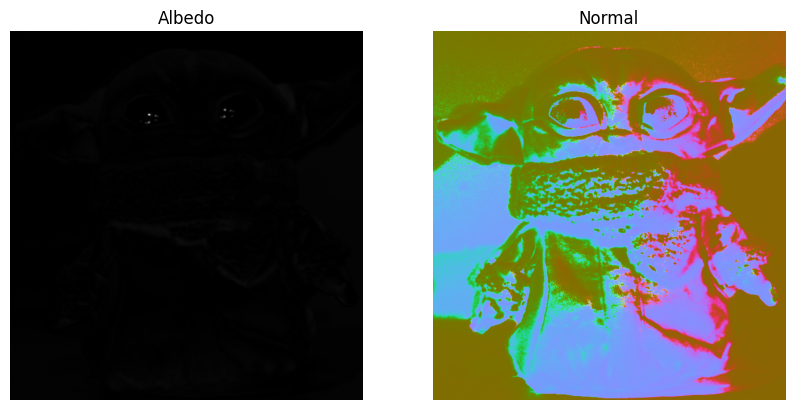

In [86]:
%matplotlib inline 
plot_2fig(A_int, N_int, 'img2_entropy_min.png', 'Albedo', 'Normal')

In [105]:
eps = 1.5e-2
zx = N_int[:, :, 0]/(N_int[:, :, 2] + eps)
zy = N_int[:, :, 1]/(N_int[:, :, 2] + eps)

# Z = integrate_frankot(zx, zy)
Z = integrate_poisson(zx, zy)
Z.min(), Z.max()

(-10888.992110912774, 6192.880532958118)

0.0 1.0


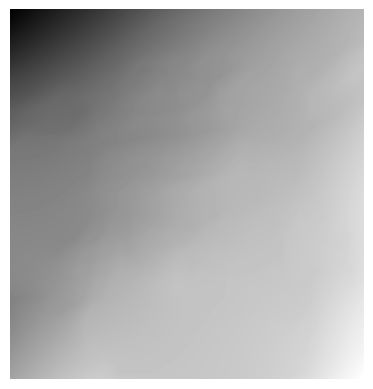

In [109]:
%matplotlib inline 
Z = normalize_01(Z)
print(Z.min(), Z.max())
plt.imshow(Z, cmap='gray')
plt.axis('off')
plt.savefig('depth_img2_entropy_min.png')

In [107]:
import PyQt5
%matplotlib qt
from matplotlib.colors import LightSource
from mpl_toolkits.mplot3d import Axes3D
# Z is an HxW array of surface depths
H, W = Z.shape
# x, y = np.meshgrid(np.arange(0,W,5), np.arange(0,H,5))
x, y = np.meshgrid(np.arange(0,W), np.arange(0,H))
print(Z.shape, x.shape, y.shape)
# set 3D figure
fig = plt.figure()
ax = fig.gca(projection='3d')
# add a light and shade to the axis for visual effect
ls = LightSource()

Z_temp = Z[0::5, 0::5]
print(Z_temp.shape)

color_shade = ls.shade(Z, plt.cm.gray)
# (control surface resolution using rstride and cstride)
ax.view_init(elev=90, azim=105)
surf = ax.plot_surface(x, y, Z, facecolors=color_shade, rstride=4, cstride=4)

# turn off axis
plt.axis('off')
plt.tight_layout()
# plt.savefig('imcddee_30.png', dpi=1200)
plt.show()

(654, 625) (654, 625) (654, 625)
(131, 125)


2023-11-23 18:22:54.108 python[9902:479415] IMKClient Stall detected, *please Report* your user scenario attaching a spindump (or sysdiagnose) that captures the problem - (imkxpc_bundleIdentifierWithReply:) block performed very slowly (1.12 secs).
2023-11-23 18:22:54.108 python[9902:479415] IMKClient Stall detected, *please Report* your user scenario attaching a spindump (or sysdiagnose) that captures the problem - (imkxpc_bundleIdentifierWithReply:) block performed very slowly (1.12 secs).
2023-11-23 18:22:56.705 python[9902:479415] +[CATransaction synchronize] called within transaction
2023-11-23 18:22:56.894 python[9902:479415] +[CATransaction synchronize] called within transaction


In [85]:
def plot_2fig(fig1, fig2, name=None, title1=None, title2=None):
    fig = plt.figure(figsize=(10, 6))
    fig.add_subplot(1, 2, 1)
    plt.imshow(fig1, cmap='gray')
    plt.title(title1)
    plt.axis('off')
    fig.add_subplot(1, 2, 2)
    plt.imshow(fig2, cmap='gray')
    plt.title(title2)
    plt.axis('off')
    if name is not None:
        plt.savefig(name, bbox_inches='tight')
    plt.show()
    
def plot_2fig_difference(fig1, fig2, name=None, title1=None, title2=None):
    fig = plt.figure(figsize=(18, 8))
    fig.add_subplot(1, 3, 1)
    plt.imshow(fig1, cmap='gray')
    plt.title(title1)
    plt.axis('off')
    fig.add_subplot(1, 3, 2)
    plt.imshow(fig2, cmap='gray')
    plt.title(title2)
    plt.axis('off')
    
    fig.add_subplot(1, 3, 3)
    plt.imshow(fig1-fig2, cmap='gray')
    plt.title('Difference')
    plt.axis('off')
    if name is not None:
        plt.savefig(name, bbox_inches='tight')
    plt.show()
    
def plot_3fig(fig1, fig2, fig3, name=None, t1=None, t2=None, t3=None):
    fig = plt.figure(figsize=(18, 8))
    fig.add_subplot(1, 3, 1)
    plt.imshow(fig1, cmap='gray')
    plt.title(t1)
    plt.axis('off')
    fig.add_subplot(1, 3, 2)
    plt.imshow(fig2, cmap='gray')
    plt.title(t2)
    plt.axis('off')
    fig.add_subplot(1, 3, 3)
    plt.imshow(fig3, cmap='gray')
    plt.title(t3)
    plt.axis('off')
    if name is not None:
        plt.savefig(name, bbox_inches='tight')
    plt.show()